# Convert Image to Sudoku quiz

In [1]:
import os
import sys
import random
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import sudoku_solver
import snet

In [2]:
# Global variables
digit_templates = {}
# Create classifier for digit identification
digit_clf = snet.SNET_Model()

In [3]:
def plot_digit_templates():
    global digit_templates
    
    num_digits = len(digit_templates)  # Number of images
    fig, axes = plt.subplots(1, num_digits, figsize=(num_digits * 2, 2))
    
    if num_digits == 1:  # Handle case for single image
        axes = [axes]
        
    for ax, (digit, image) in zip(axes, digit_templates.items()):
        ax.imshow(image, cmap='gray')  # Adjust cmap for grayscale
        ax.set_title(f"Digit: {digit}")
        ax.axis("off")  # Hide axes
    
    plt.show()
    
def load_templates():
    global digit_templates
    
    dir = r'datasets\digit_templates'
    files = os.listdir(dir)
    for file in files:    
        img_gray = cv.imread(os.path.join(dir,file), cv.IMREAD_GRAYSCALE)
        img_th = cv.adaptiveThreshold(img_gray,255,cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY,11,2)
        resized_img = cv.resize(img_th, (100,100), interpolation=cv.INTER_NEAREST)
        file_name = os.path.splitext(os.path.basename(file))[0]
        digit_templates[file_name]  = resized_img
    
def filter_close_coordinates(coordinates, min_distance=10):
    """Remove coordinates that are too close to each other."""
    filtered = []

    for coord_1 in coordinates:
        preserve = True
        for coord_2 in filtered:
            distance = np.linalg.norm(coord_1 - coord_2)
            if distance > min_distance:
                continue
            else:
                preserve = False
                break
        if preserve:
            filtered.append(coord_1) 
    return filtered 

def get_coords_of_lines(corner_coords):
    corner_coords.sort(key= lambda coord: coord[0]) # sort based on y coordinate
    vertical_lines_coords = [int(coord[1]) for coord in corner_coords[0:10]] # get the 10 smallest y coordinates
    vertical_lines_coords.sort() # the x coordiantes of the vertical lines

    corner_coords.sort(key= lambda coord: coord[1]) # sort based on x coordinate
    horizontal_lines_coords = [int(coord[0]) for coord in corner_coords[0:10]] # get the 10 smallest x coordinates
    horizontal_lines_coords.sort() # the xycoordiantes of the horizontal lines, y = horizontal_lines
    return vertical_lines_coords, horizontal_lines_coords

def crop_img(img, scale=1.0):
    center_x, center_y = img.shape[1] / 2, img.shape[0] / 2
    width_scaled, height_scaled = img.shape[1] * scale, img.shape[0] * scale
    left_x, right_x = center_x - width_scaled / 2, center_x + width_scaled / 2
    top_y, bottom_y = center_y - height_scaled / 2, center_y + height_scaled / 2
    img_cropped = img[int(top_y):int(bottom_y), int(left_x):int(right_x)]
    return img_cropped

def get_sqr_sub_image(img, row: int, col: int, vert_lines: list, hori_lines: list):
    x_min = vert_lines[col]
    x_max = vert_lines[col+1]
    y_min = hori_lines[row]
    y_max = hori_lines[row+1]
    sqr_sub_image = img[y_min:y_max,x_min:x_max]
    cropped_image = crop_img(sqr_sub_image, 0.8)
    img_blur = cv.GaussianBlur(cropped_image,(11,11),0)
    img_th = cv.adaptiveThreshold(img_blur,255,cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY,5,1)
    resized_img = cv.resize(img_th, (32,32), interpolation=cv.INTER_NEAREST)
    return resized_img

def detect_digit(images) -> str:
    """
    Returns the most likely digit in the image using the trained classifier.
    """
    global digit_clf
    digit_list = digit_clf.predict_digits(images)
    str_digits = "".join([str(digit) for digit in digit_list])
    return str_digits
 
def image_to_string(img, vertical_lines_coords, horizontal_lines_coords):
    output_str = ''
    cell_images = []
    for row in range(0,9):
        for col in range(0,9):
            cell_img = get_sqr_sub_image(img, row, col, vertical_lines_coords, horizontal_lines_coords)
            cell_images.append(cell_img)
            
    output_str = detect_digit(cell_images)
    return output_str

## Load Image and Perform Preprocessing

The image is expetced to be screenshot of a sudoku quiz from [this website](https://sudoku.com/). The image must only contain the entire quize grid. 

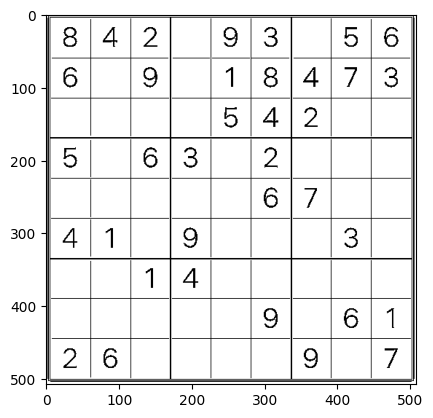

In [4]:
img_gray = cv.imread("inputs/images/quiz_3.png", cv.IMREAD_GRAYSCALE)
img_rgb = cv.cvtColor(img_gray,cv.COLOR_GRAY2RGB)

_, img_th1 = cv.threshold(img_gray,230,255,cv.THRESH_BINARY)

img_th2 = cv.adaptiveThreshold(img_gray,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY,5,3)

if img_gray is None:
    sys.exit("Could not read the image.")

plt.imshow(img_th2, cmap='binary_r', vmax=255, vmin=0)
plt.show()

## Detect Harris Corners

Harris corners are detected to find the locations of corners in the image. Which will be used to determine the locations the individual cells within the grid.

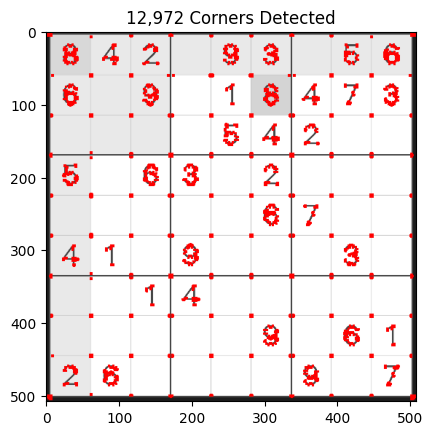

In [5]:
dst = cv.cornerHarris(img_th2,2,3,0.04)
 
#result is dilated for marking the corners, not important
dst = cv.dilate(dst,None)
 
# Threshold for an optimal value, it may vary depending on the image.
img_harris = img_rgb.copy()

corner_condition = dst>0.01*dst.max()
detected_harris_n = (corner_condition).sum()
corner_coords = np.argwhere(corner_condition)

img_harris[corner_condition]=[255,0,0] # draw corner points 

plt.title(f'{detected_harris_n:,} Corners Detected')
plt.imshow(img_harris)
plt.show()

## Remove Corners that are too Close

Remove corners that have beed detected more than once / only keep 1 corners at locations where multiple were detected.

In [6]:
# timer = time.time()
corner_coords_reduced = filter_close_coordinates(corner_coords, 15)
# timer = timer - time.time()

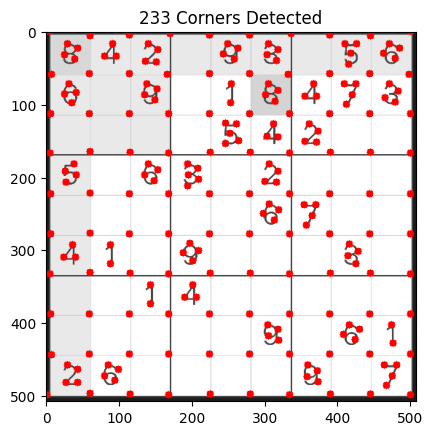

In [7]:
img_harris_reduced = img_rgb.copy()
for (y, x) in corner_coords_reduced:
    cv.circle(img_harris_reduced, (x, y), radius=5, color=(255, 0, 0), thickness=-1)
corner_coords_reduced_n = len(corner_coords_reduced)
plt.title(f'{corner_coords_reduced_n:,} Corners Detected')
plt.imshow(img_harris_reduced)
plt.show()   

## Get Sub-Images of Indivual Cells

Sample sub-images of the individual cells such that they can be further processed to determine the number within each cell.

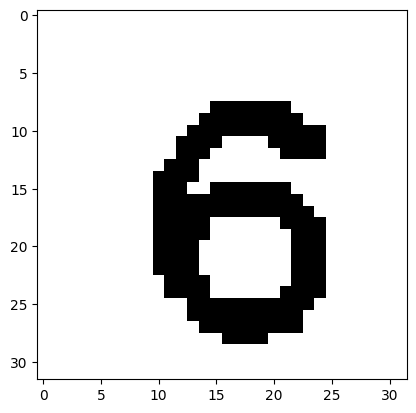

In [8]:
# View a digit within a cell 
vertical_lines_coords, horizontal_lines_coords = get_coords_of_lines(corner_coords_reduced)
sqr_img = get_sqr_sub_image(img_th2, 3, 2, vertical_lines_coords, horizontal_lines_coords)
plt.imshow(sqr_img, cmap='gray', vmax=255, vmin=0)
plt.show()

## Predict the Digit Within the Cell

In [9]:
# Predict the digit within the cell with the model/classifier 
pred_digit= digit_clf.predict_digits([sqr_img])
print(f"The predicted digit is {pred_digit}")

The predicted digit is [6]


## Get All Cell Values

In [10]:
raw_quiz_str = ''
cell_images = []
for row in range(0,9):
    for col in range(0,9):
        cell_img = get_sqr_sub_image(img_th2, row, col, vertical_lines_coords, horizontal_lines_coords)
        cell_images.append(cell_img)
        
raw_quiz_str = detect_digit(cell_images)

In [ ]:
print(f"The raw sudoku quiz string:\n{raw_quiz_str}")
quiz_array = sudoku_solver.quiz_str_to_grid(raw_quiz_str)
quiz_str = sudoku_solver.sudoku_grid_to_string(quiz_array)
print(f"\nFormatted String:\n{quiz_str}")

The raw sudoku quiz string:
842093056609018473000054200506302000000006700410900030001400000000009061260000907

Formated String:
8 4 2 | . 9 3 | . 5 6
6 . 9 | . 1 8 | 4 7 3
. . . | . 5 4 | 2 . .
---------------------
5 . 6 | 3 . 2 | . . .
. . . | . . 6 | 7 . .
4 1 . | 9 . . | . 3 .
---------------------
. . 1 | 4 . . | . . .
. . . | . . 9 | . 6 1
2 6 . | . . . | 9 . 7


## Complete Solution

In [12]:
def image_to_sudoku_quiz(f_path) -> str:
    
    # load image and preprocess
    img_gray = cv.imread(f_path, cv.IMREAD_GRAYSCALE)
    img_th = cv.adaptiveThreshold(img_gray,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY,5,3)
    
    # detect corner feature
    dst = cv.cornerHarris(img_th,2,3,0.04)
    dst = cv.dilate(dst,None)
    corner_condition = dst>0.01*dst.max()
    corner_coords = np.argwhere(corner_condition)
    corner_coords_reduced = filter_close_coordinates(corner_coords, 15) # reduce corners
    
    # get coordinates of lines
    vertical_lines_coords, horizontal_lines_coords = get_coords_of_lines(corner_coords_reduced)
    
    # generate string 
    raw_string = image_to_string(img_th, vertical_lines_coords, horizontal_lines_coords)

    return raw_string

In [13]:
# View initial Grid
out_str = image_to_sudoku_quiz("inputs/images/quiz_3.png")
quiz_array = sudoku_solver.quiz_str_to_grid(out_str)
out_str = sudoku_solver.sudoku_grid_to_string(quiz_array)
print(f"Quiz generated from image:\n{out_str}")

Quiz generated from image:
8 4 2 | . 9 3 | . 5 6
6 . 9 | . 1 8 | 4 7 3
. . . | . 5 4 | 2 . .
---------------------
5 . 6 | 3 . 2 | . . .
. . . | . . 6 | 7 . .
4 1 . | 9 . . | . 3 .
---------------------
. . 1 | 4 . . | . . .
. . . | . . 9 | . 6 1
2 6 . | . . . | 9 . 7


In [14]:
# Solve quiz
solver = sudoku_solver.Solver(quiz_array)
solution_grid = solver.solve()
solution_str = sudoku_solver.sudoku_grid_to_string(solution_grid)
print(f"Quiz solution:\n{solution_str}")

Quiz solution:
8 4 2 | 7 9 3 | 1 5 6
6 5 9 | 2 1 8 | 4 7 3
1 7 3 | 6 5 4 | 2 8 9
---------------------
5 9 6 | 3 7 2 | 8 1 4
3 2 8 | 1 4 6 | 7 9 5
4 1 7 | 9 8 5 | 6 3 2
---------------------
9 3 1 | 4 6 7 | 5 2 8
7 8 4 | 5 2 9 | 3 6 1
2 6 5 | 8 3 1 | 9 4 7
